In [1]:
%pylab inline
import numpy as np
from scipy.spatial.distance import cdist
import sys
sys.path.append("../")
import sgd
reload(sgd)
import theano
import theano.tensor as T
import topogen
import sklearn.datasets
import util
import cPickle as pickle
import exputil
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import sklearn.metrics

Populating the interactive namespace from numpy and matplotlib


(1600, 1600)


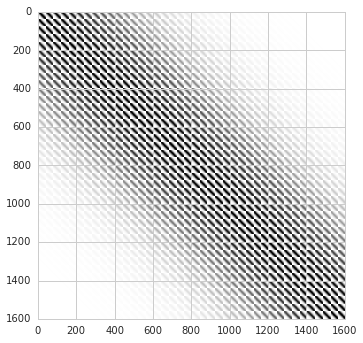

In [2]:
import kernels
reload(kernels)
reload(exputil)

kern_func = kernels.gaussian(1.0) # , 3.0)

kern_f = exputil.make_kern_f(kern_func)
N = 40
x = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, x)
points = np.array([xv.flatten(), yv.flatten()]).T
#points = np.meshgrid()
r  = kern_f(points, None)
print r.shape
pylab.imshow(r, interpolation='nearest')
pylab.figure()
pylab.imshow(r[N**2/2 + N/2].reshape((N, N)), interpolation='nearest')
pylab.figure()
pylab.plot(x, r[N**2/2 + N/2].reshape((N, N))[N/2])

In [3]:
reload(sgd)
import losses
reload(losses)
N = 1000
D = 2

lossobj = losses.Logistic(0.5)

#xtrue = np.random.normal(0, 1, (N, D))
xtrue = topogen.sample_sphere(N, D) + np.random.normal(0, 0.0001, (N, D))
print xtrue.shape
print kern_f(xtrue, None).shape
kern_val = kern_f(xtrue, None)
obs = lossobj.obs_forward(kern_val)
print obs.shape

obs_frac = 0.90
obsvalid = np.random.rand(*obs.shape) < obs_frac

xinit = np.random.normal(0, 1, (N, D))
pylab.imshow(obs, interpolation='nearest', cmap=pylab.cm.gray_r)
pylab.colorbar()

(1000, 2)
(1000, 1000)
(1000, 1000)


<matplotlib.colorbar.Colorbar instance at 0x7f50c510ec68>

/opt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [31]:
### 
reload(sgd)
reload(exputil)
import time

XINIT_N = 4
#xinit = [np.random.normal(0, std, (N, D)) for std in np.logspace(-1.5, 1, XINIT_N)]
xinit = [np.random.normal(0, 0.1, (N, D)) for _ in range(XINIT_N)]
#xinit.append(xtrue.copy())
xinit = np.array(xinit)
print xinit.shape

ALPHAS = np.logspace(0.5, -1, 5)
BATCH_RATIOS = np.array([0.025, 0.05, 0.1, 0.2, 0.4])
t1 = time.time()
res = exputil.sgd_param_test_par(kern_func, lossobj.cost(), 
                            xinit, None,  obs,  np.ones_like(obs), 
                            alphas = ALPHAS, batch_ratios= BATCH_RATIOS, 
                            use_adagrad = True, 
                            theta_inference=False, iters=200)
t2 = time.time()
print "took", t2-t1, "secs"

(4, 1000, 2)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
took 87.6400039196 secs


../sgd.py:346: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: theta.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
../sgd.py:346: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: theta.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
../sgd.py:346: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at in

In [34]:
# pick best
reload(exputil)
exputil.get_best_run_params(res)

{'alpha': 1.333521432163324,
 'batch_ratio': 0.40000000000000002,
 'exp_iter': 0,
 'obj': array(-271622.77635026985),
 'objiter': 190,
 'xinit_i': 0}

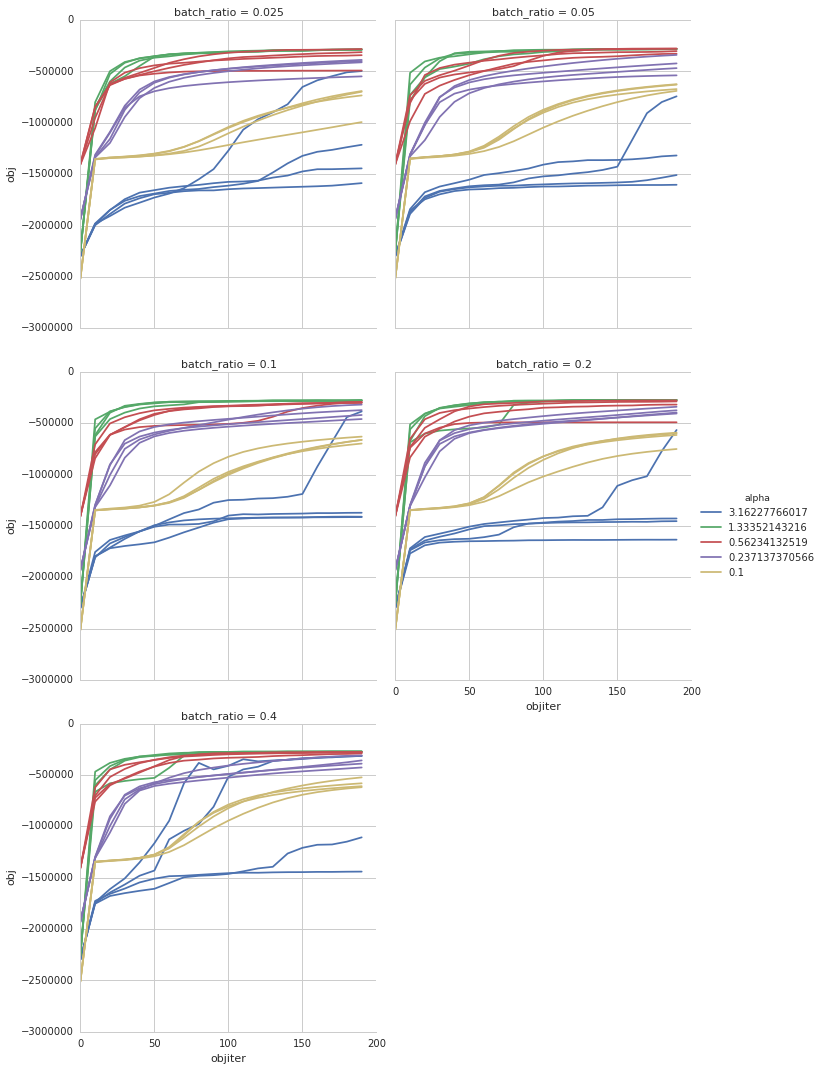

In [35]:
allres = []
for r in res:
    for oi, o in enumerate(r['obj_log']):
        rc = r.copy()
        del rc['obj_log']
        rc['obj'] = o
        rc['objiter'] = oi*10
        allres.append(rc)
df = pd.DataFrame(allres)
def mdf(arg1, arg2, data, color, label):
    for gi, g in data.groupby('xinit_i'):
        pylab.plot(g[arg1], g[arg2], c=color, label=label
                  )
grid = sns.FacetGrid(df, col="batch_ratio", hue="alpha", col_wrap=2, size=5)


# Draw a line plot to show the trajectory of each random walk
#grid.map(plt.plot, "objiter", "obj") # , marker="o", ms=4)
grid.map_dataframe(mdf, 'objiter', 'obj')
# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)
sns.despine()
grid.add_legend()